# ***Data Cleaning of Casas_venta***

## **Importing Libraries & loading Data**

In [0]:
# Import libraries
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
# Loading 'Casas_venta_LaVoz.csv', 'Casas_venta_zonaprop.csv', and 'Casas_venta_argenprop.csv' 
df1 = pd.read_csv('data/Casas_venta_LaVoz.csv')
df1.columns = df1.columns.str.replace('Apto Crédito:','Apto Crédito')
df1.drop(columns=['Unnamed: 0'], inplace=True)
print('Lenght:',len(df1))

df2 = pd.read_csv('data/Casas_venta_zonaprop.csv')
df2.drop(columns=['Unnamed: 0'], inplace=True)
print('Lenght:',len(df2))

df3 = pd.read_csv('data/Casas_venta_argenprop.csv')
df3.drop(columns=['Unnamed: 0'], inplace=True)
print('Lenght:',len(df3))

Lenght: 13491
Lenght: 7198
Lenght: 2797


In [0]:
df = pd.concat([df1,df2,df3])
df = df.reset_index()
df.drop(columns=['index'], inplace=True)
for i in df.columns:
  df[i] = df[i].astype(str)
  df[i] = df[i].replace('nan',np.NaN)
print('Lenght:',len(df))
df.head()

Lenght: 23486


,Tipo de Propiedad,Zona,Ciudad,Barrio,Calle,Tipo de Barrio,Apto Escritura,Apto Crédito,Etapa de Construcción,Antigüedad,Cantidad de Plantas,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Cobertura Cocheras,Superficie Total m2,Superficie Cubierta m2,Valor
0,Duplex,NaN,Córdoba,Claros del Bosque,Claros Del Bosque 5000,NaN,NaN,nan,NaN,NaN,2 Plantas,3 Dormitorios,3 Baños,1,Cubierta,180,160,185000
1,Duplex,Sur,Córdoba,Greenville 2,NaN,Con Seguridad,NaN,nan,NaN,NaN,NaN,3 Dormitorios,NaN,NaN,NaN,NaN,NaN,225000
2,Casa,NaN,Villa Allende,La Herradura,01 1,Country,NaN,nan,NaN,NaN,2 Plantas,3 Dormitorios,3 Baños,2,Cubierta,1592,400,380000
3,Casa,Norte,Córdoba,Villa Belgrano,NaN,Abierto,Si,nan,NaN,25 años,1 Planta,3 Dormitorios,4 Baños,2,Cubierta,1.200 mts2,446 mts2,420000
4,Casa,NaN,Córdoba,Maipu Sección 2,Benjamin Igarzabal 1300,NaN,NaN,nan,NaN,NaN,NaN,4 Dormitorios,4 Baños,2,Cubierta,350,316,250000


In [0]:
# selecting houses only from Córdoba city and its surrounding ('Gran Córdoba')
col = ['Córdoba', 'Villa Allende', 
       'Mendiolaza','La Calera', 
       'Valle Escondido','Guiñazú',
       'Malagueño', 'Pdo. de Cordoba Capital'
       'Countries y Barrios Cerrados Cordoba Capital']

df = df.loc[(df.Ciudad == col[0]) | 
            (df.Ciudad == col[1]) | 
            (df.Ciudad == col[2]) | 
            (df.Ciudad == col[3]) | 
            (df.Ciudad == col[4]) | 
            (df.Ciudad == col[5]) |
            (df.Ciudad == col[6]) |
            (df.Ciudad == col[7]) 
           ] 
len(df) # lenght: 15938 rows

15938

## **Main feature/dependent variable/ ('Valor)'**

In [0]:
# Dropping rows with NaN values in 'Valor'
df.dropna(subset=['Valor'], inplace=True) 
len(df) #lenght: 7375 rows

13158

In [0]:
# Converting 'Valor' values into float
df.Valor = df.Valor.str.extract('(\d+)').astype(float)

In [0]:
# dropping values < U$S 5.000.000 and > 10000 to avoid possible error-numbers from collected data
df = df.loc[(df.Valor < 5000000) & (df.Valor > 5000)]

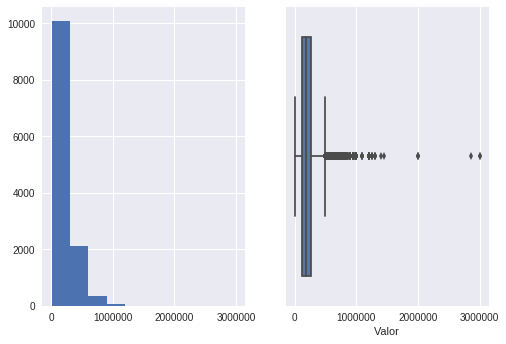

In [0]:
# First approximation to 'Valor', looking for outliers and shape of distribution
plt.subplot(1, 2, 1)
plt.hist(df.Valor)
plt.subplot(1, 2, 2)
sns.boxplot(df.Valor)
plt.show()

Lenght: 12548


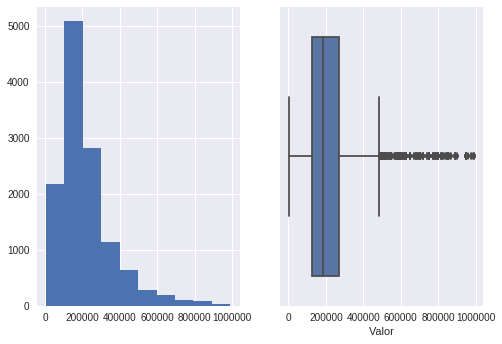

In [0]:
# Cleaning big outliers
df = df.loc[(df.Valor < 1000000)]
plt.subplot(1, 2, 1)
plt.hist(df.Valor)
plt.subplot(1, 2, 2)
sns.boxplot(df.Valor)
print('Lenght:',len(df))
plt.show()

## **Categorical Features**

In [0]:
# Looking for # of NaN in each feature
t = {}
for i in df.columns:
  t[i] = (df[i].isnull().sum())
sorted(t.items(), key=itemgetter(1))

[('Ciudad', 0),
 ('Valor', 0),
 ('Tipo de Propiedad', 299),
 ('Cantidad de Dormitorios', 787),
 ('Barrio', 1798),
 ('Calle', 2719),
 ('Superficie Total m2', 3220),
 ('Superficie Cubierta m2', 3400),
 ('Cantidad de Baños', 3764),
 ('Cantidad de Cocheras', 6147),
 ('Antigüedad', 6472),
 ('Cantidad de Plantas', 7488),
 ('Tipo de Barrio', 8070),
 ('Apto Escritura', 9029),
 ('Cobertura Cocheras', 9376),
 ('Zona', 9715),
 ('Etapa de Construcción', 9992),
 ('Apto Crédito', 12548)]

In [0]:
# Removing columns with either hight number of NaN or no relevance
columns = ['Tipo de Propiedad',
           'Zona', # although it has a big number of NaN, I will impute them with data from other source
           'Barrio',
           'Calle',
           'Tipo de Barrio', # although it has a big number of NaN, I will impute them with data from other source
           'Cantidad de Dormitorios',
           'Cantidad de Baños', # although it has a big number of NaN, I will impute them with its mode
           'Cantidad de Cocheras',
           'Cobertura Cocheras',
           'Superficie Cubierta m2',
           'Superficie Total m2',
           'Valor'
          ]

df = df[columns]
df.head()

,Tipo de Propiedad,Zona,Barrio,Calle,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Cobertura Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor
0,Duplex,NaN,Claros del Bosque,Claros Del Bosque 5000,NaN,3 Dormitorios,3 Baños,1,Cubierta,160,180,185000.000
1,Duplex,Sur,Greenville 2,NaN,Con Seguridad,3 Dormitorios,NaN,NaN,NaN,NaN,NaN,225000.000
2,Casa,NaN,La Herradura,01 1,Country,3 Dormitorios,3 Baños,2,Cubierta,400,1592,380000.000
3,Casa,Norte,Villa Belgrano,NaN,Abierto,3 Dormitorios,4 Baños,2,Cubierta,446 mts2,1.200 mts2,420000.000
4,Casa,NaN,Maipu Sección 2,Benjamin Igarzabal 1300,NaN,4 Dormitorios,4 Baños,2,Cubierta,316,350,250000.000


### **Cleaning 'Tipo de Propiedad'**

In [0]:
# Droping the few rows with an empty element in the column 'Tipo de Propiedad'
df.dropna(subset=['Tipo de Propiedad'], inplace=True)
print('Tipo de Propiedad:', df['Tipo de Propiedad'].unique())

Tipo de Propiedad: ['Duplex' 'Casa' 'Chalet' 'Casa Quinta' 'Triplex' 'Prefabricada' 'Cabaña'
 'Departamento']


In [0]:
for i in df['Tipo de Propiedad'].unique():
  print(i+':', len(df.loc[df['Tipo de Propiedad'] == i]) )

Duplex: 825
Casa: 11390
Chalet: 10
Casa Quinta: 6
Triplex: 11
Prefabricada: 1
Cabaña: 1
Departamento: 5


In [0]:
# Removing values 'Chalet', 'Triplex', 'Casa Quinta' & 'Cabaña' as their sum is 12 
df = df.loc[(df['Tipo de Propiedad'] == 'Duplex') | (df['Tipo de Propiedad'] == 'Casa') ]
print('Tipo de Propiedad:', df['Tipo de Propiedad'].unique())
print('Lenght:', len(df))

Tipo de Propiedad: ['Duplex' 'Casa']
Lenght: 12215


### **Cleaning 'Cantidad de Cocheras' & 'Cobertura Cocheras'**

In [0]:
# Replacing NaN from 'Cantidad de Cocheras' with value '1' when 'Cobertura Cocheras' is not null
df['Cantidad de Cocheras'] = np.where((df['Cantidad de Cocheras'].isnull()) & (df['Cobertura Cocheras'].notnull()), '1', df['Cantidad de Cocheras'])
df['Cantidad de Cocheras'] = df['Cantidad de Cocheras'].astype(float)
df['Cantidad de Cocheras'] = np.where(df['Cantidad de Cocheras'] > 4, 5, df['Cantidad de Cocheras'])
df.drop(columns=['Cobertura Cocheras'], inplace=True)
df['Cantidad de Cocheras'].unique()

array([ 1., nan,  2.,  3.,  4.,  5.,  0.])

In [0]:
# Creating a new column with data about the NaN status of each row (true/false)
df['Cantidad de Cocheras' + '_was_missing'] = df['Cantidad de Cocheras'].isnull()

In [0]:
# Imputing NaN values with value '0'
df['Cantidad de Cocheras'].fillna(0, inplace=True)
print('Total NaN Cantidad de Cocheras:', df['Cantidad de Cocheras'].isnull().sum())
print('Lenght:',len(df))
df.head()

Total NaN Cantidad de Cocheras: 0
Lenght: 12215


,Tipo de Propiedad,Zona,Barrio,Calle,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing
0,Duplex,NaN,Claros del Bosque,Claros Del Bosque 5000,NaN,3 Dormitorios,3 Baños,1.000,160,180,185000.000,False
1,Duplex,Sur,Greenville 2,NaN,Con Seguridad,3 Dormitorios,NaN,0.000,NaN,NaN,225000.000,True
2,Casa,NaN,La Herradura,01 1,Country,3 Dormitorios,3 Baños,2.000,400,1592,380000.000,False
3,Casa,Norte,Villa Belgrano,NaN,Abierto,3 Dormitorios,4 Baños,2.000,446 mts2,1.200 mts2,420000.000,False
4,Casa,NaN,Maipu Sección 2,Benjamin Igarzabal 1300,NaN,4 Dormitorios,4 Baños,2.000,316,350,250000.000,False


### **Cleaning 'Cantidad de Dormitorios' & 'Cantidad de Baños'**

In [0]:
# Getting kind of values from 'Cantidad de Dormitorios' & 'Cantidad de Baños' 
print('Cantidad de Dormitorios:', df['Cantidad de Dormitorios'].unique())
print('Cantidad de Baños:', df['Cantidad de Baños'].unique())

Cantidad de Dormitorios: ['3 Dormitorios' '4 Dormitorios' '2 Dormitorios' 'Más de 4 Dormitorios'
 nan '1 Dormitorio' 'Monoambiente' '3.0' '2.0' '4.0' '5.0' '0.0' '7.0'
 '6.0' '14.0' '8.0' '10.0' '1.0']
Cantidad de Baños: ['3 Baños' nan '4 Baños' '2 Baños' '1 Baño' 'Más de 4 Baños' '3.0' '4.0'
 '2.0' '0.0' '5.0' '6.0' '7.0' '10.0' '8.0' '1.0']


In [0]:
# Replacing their values with numerical data  
l = df['Cantidad de Dormitorios'].loc[df['Cantidad de Dormitorios'] == 'Monoambiente']
df['Cantidad de Dormitorios'].replace(l, '5', inplace=True)
l = df['Cantidad de Dormitorios'].loc[df['Cantidad de Dormitorios'] == 'Más de 4 Dormitorios']
df['Cantidad de Dormitorios'].replace(l, '5', inplace=True)
l = df['Cantidad de Baños'].loc[df['Cantidad de Baños'] == 'Más de 4 Baños']
df['Cantidad de Baños'].replace(l, '5', inplace=True)
df['Cantidad de Dormitorios'] = df['Cantidad de Dormitorios'].astype(str).str.extract('(\d+)').astype(float)
df['Cantidad de Baños'] = df['Cantidad de Baños'].astype(str).str.extract('(\d+)').astype(float)

In [0]:
df['Cantidad de Dormitorios'] = np.where(df['Cantidad de Dormitorios'] > 4, 5, df['Cantidad de Dormitorios'])
df['Cantidad de Dormitorios'] = np.where(df['Cantidad de Dormitorios'] == 0, np.NaN, df['Cantidad de Dormitorios'])
df['Cantidad de Baños'] = np.where(df['Cantidad de Baños'] > 4, 5, df['Cantidad de Baños'])
df['Cantidad de Baños'] = np.where(df['Cantidad de Baños'] == 0, np.NaN, df['Cantidad de Baños'])
print('Cantidad de Dormitorios:', df['Cantidad de Dormitorios'].unique())
print('Cantidad de Baños:', df['Cantidad de Baños'].unique())

Cantidad de Dormitorios: [ 3.  4.  2.  5. nan  1.]
Cantidad de Baños: [ 3. nan  4.  2.  1.  5.]


In [0]:
# Creating new columns with data about the replacement of NaN
for i in ['Cantidad de Dormitorios','Cantidad de Baños']:
  df[i + '_was_missing'] = df[i].isnull()

In [0]:
# Imputing NaN values with their modes
df['Cantidad de Dormitorios'].fillna(df['Cantidad de Baños'].mode()[0], inplace=True)
df['Cantidad de Baños'].fillna(df['Cantidad de Baños'].mode()[0], inplace=True)
print('Total NaN Cantidad de Dormitorios:', df['Cantidad de Dormitorios'].isnull().sum())
print('Total NaN Cantidad de Baños:',df['Cantidad de Baños'].isnull().sum())
print('Lenght:',len(df))
df.head()

Total NaN Cantidad de Dormitorios: 0
Total NaN Cantidad de Baños: 0
Lenght: 12215


,Tipo de Propiedad,Zona,Barrio,Calle,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing
0,Duplex,NaN,Claros del Bosque,Claros Del Bosque 5000,NaN,3.000,3.000,1.000,160,180,185000.000,False,False,False
1,Duplex,Sur,Greenville 2,NaN,Con Seguridad,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True
2,Casa,NaN,La Herradura,01 1,Country,3.000,3.000,2.000,400,1592,380000.000,False,False,False
3,Casa,Norte,Villa Belgrano,NaN,Abierto,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False
4,Casa,NaN,Maipu Sección 2,Benjamin Igarzabal 1300,NaN,4.000,4.000,2.000,316,350,250000.000,False,False,False


### **Cleaning 'Barrio'**

In [0]:
# Replacing value 'Córdoba' in 'Barrio' with values from 'Calle'
df.Barrio = np.where(df.Barrio == 'Córdoba', df.Calle, df.Barrio)

# Dropping column 'Calle'
df.drop(columns=['Calle'], inplace=True)

# Converting data from 'Barrio' as string
df['Barrio'] = df['Barrio'].astype(str)

# Removing specific chars in 'Barrio'
df.Barrio = [i.replace('.','') for i in df.Barrio] 
df.Barrio = [i.replace('Los Carolinos','Lomas de la Carolina') for i in df.Barrio] 
df.Barrio = [i.replace('Urbanización Inteligente','') for i in df.Barrio]
df.Barrio = [i.replace('Barrio Privado','') for i in df.Barrio]
df.Barrio = [i.replace('Urbanizacion Residencial','') for i in df.Barrio] 
df.Barrio = [i.replace('Villa Urbana','') for i in df.Barrio] 
df.Barrio = [i.replace('Urbanización','') for i in df.Barrio] 
df.Barrio = [i.replace('El Jockey','Jockey Club') for i in df.Barrio] 
df.Barrio = [i.replace('El Talar','El Talar de Mendiolaza') for i in df.Barrio] 
df.Barrio = [i.replace('4','Cuatro') for i in df.Barrio] 
df.Barrio.loc[df.Barrio != 'Solares de San Alfonso'] = [i.replace('San Alfonso','San Alfonso del Talar') for i in df.Barrio if i != 'Solares de San Alfonso' ] 
df.Barrio.loc[df.Barrio != 'Country Club'] = [i.replace('Country','') for i in df.Barrio if i != 'Country Club' ]
df.Barrio.loc[(df.Barrio != 'Centro')&(df.Barrio != 'Centro América')] = [i.replace('Centro','') for i in df.Barrio if (i != 'Centro' and i != 'Centro América')]

In [0]:
# Loading 'Barrios.csv', which contains the name and 'Zona' for each 'Barrio'
barrios = pd.read_csv('/data/barrios/Barrios.csv')
barrios.drop(columns=['Unnamed: 0'], inplace=True)
barrios.head()

,Zona Central,Zona Norte,Zona Sur,Zona Este,Zona Oeste,Zona Nordeste,Zona Noroeste,Zona Sudeste,Zona Sudoeste,Zona Cerro-Argüello,Zona Guiñazú
0,Cáceres,Parque Liceo Sección 1,Mirizzi,General Pueyrredón,Ampliación Las Palmas,La Hortensia,San Martín Anexo,José Ignacio Díaz Sección 5,Guarnición Aérea Córdoba,Villa Serrana,Guiñazú Sud
1,Güemes,Cofico,Irupé,Yofre Sud,Chateau Carreras,Residencial Aragón,San Martín Norte,Mirador,Ampliación Rosedal,Parque Modelo,Guiñazú
2,Nueva Córdoba,Jerónimo Luis de Cabrera,San Antonio,Hogar Propio,Puente Blanco,Vivero Norte,Las Margaritas,Ampliación San Pablo,Parque Republica,UOCRA,Remedios de Escalada
3,Observatorio,Ampliación Panamericano,Cabo Farina,Juniors,Ampliación Los Plátanos,Villa Retiro,Lomas de San Martín,Villa Revol,Achával Peña,Granja de Funes,Recreo del Norte
4,Paso de los Andes,Panamericano,Vicor,Ampliación Yapeyú,Villa Siburu,Parque Liceo Sección 3,Altos de Villa Cabrera,Ferroviario Mitre,Residencial Olivos,Villa 9 de Julio,Liceo General Paz


In [0]:
# Cleaning 'Barrio's values by comparing them with the fixed dataset of barrios's name in 'Barrios.csv'
import unicodedata
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)
  
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

barr = []

for i in df.Barrio:
  similar_ratio = []
  if i == 'nan':
    barr.append('nan')
  elif i == 'Otro':
    barr.append('nan')
  else:
    for j in barrios.astype(str).values:
      valor_ratio = []
      for x in j:
        valor_ratio.append([similar(strip_accents(i.lower()), strip_accents(x.lower())), x])
      similar_ratio.append(valor_ratio)
    comparable = []
    for ratio in similar_ratio:
      comparable.append(max(ratio)) 
    if max(comparable)[0]>=0.7:
      barr.append(max(comparable)[1])
    else:
      barr.append('nan')

s = pd.DataFrame(barr, columns=['Barrio2'])
df = df.reset_index(drop=True)
df.Barrio = s.Barrio2
df.head()

Claros del Bosque | Claros del Bosque | 1.0
Greenville 2 | Greenville 2 | 1.0
La Herradura | La Herradura | 1.0
Villa Belgrano | Villa Belgrano | 1.0
Maipu Sección 2 | Maipú Sección 2 | 1.0
San Isidro | San Isidro | 1.0
Maipu Sección 2 | Maipú Sección 2 | 1.0
Manantiales | Manantiales | 1.0
Arguello | Argüello | 1.0
General Paz | General Paz | 1.0
Urca | Urca | 1.0
Urca | Urca | 1.0
Zumaran | Zumaran | 1.0
Parque Horizonte | Parque Horizonte | 1.0
Urca | Urca | 1.0
Claros del Bosque | Claros del Bosque | 1.0
Solares de Santa María | Solares de Santa María | 1.0
Matienzo | Matienzo | 1.0
La Cuesta | La Cuesta | 1.0
Chacra del Norte | Chacra del Norte | 1.0
La Rufina | La Rufina | 1.0
Villa Warcalde | Villa Warcalde | 1.0
Alta Córdoba | Alta Córdoba | 1.0
Comarca de Allende | Comarca de Allende | 1.0
Chacra del Norte | Chacra del Norte | 1.0
El Rodeo | El Rodeo | 1.0
Golf | Golf | 1.0
Nueva Córdoba | Nueva Córdoba | 1.0
Alto Alberdi | Alto Alberdi | 1.0
Nueva Córdoba | Nueva Córdoba | 1.

,Tipo de Propiedad,Zona,Barrio,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing
0,Duplex,NaN,Claros del Bosque,NaN,3.000,3.000,1.000,160,180,185000.000,False,False,False
1,Duplex,Sur,Greenville 2,Con Seguridad,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True
2,Casa,NaN,La Herradura,Country,3.000,3.000,2.000,400,1592,380000.000,False,False,False
3,Casa,Norte,Villa Belgrano,Abierto,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False
4,Casa,NaN,Maipú Sección 2,NaN,4.000,4.000,2.000,316,350,250000.000,False,False,False


In [0]:
# Creating a new column containing references about the replaced NaN values in 'Barrio'
df.Barrio = df.Barrio.replace('nan',np.NaN)
print('Lenght of Barrio\'s NaN:', len(df.loc[df.Barrio.isnull()]))
print('Lenght of Barrios NaN & Zonas NaN:', len(df.loc[ (df.Zona.isnull()) & (df.Barrio.isnull())]) ) 
df['Barrio_was_missing'] = df.Barrio.isnull()

# Removing rows with NaN in both 'Zona' and 'Barrio'
print('Lenght of dataframe befores removing:', len(df))
df = df.loc[ (df.Zona.notnull()) | (df.Barrio.notnull()) ] 
print('Lenght of dataframe after removing:', len(df))

# Imputing NaN values from 'Barrio' with the value 'Otro'
df.Barrio.fillna('Otro',inplace=True)
print('Lenght of Barrio\'s NaN:', len(df.loc[df.Barrio.isnull()]))
print('Lenght of dataframe:', len(df))

Lenght of Barrio's NaN: 2995
Lenght of Barrios NaN & Zonas NaN: 2711
Lenght of dataframe befores removing: 12215
Lenght of dataframe after removing: 9504
Lenght of Barrio's NaN: 0
Lenght of dataframe: 9504


### **Cleaning 'Zona' **

In [0]:
# Converting data from 'Zona' as string
df['Zona'] = df['Zona'].astype(str)

In [0]:
# Inserting a new column 'Zonas' with zone-values got from comparing 'Barrios' with the data in 'Barrios.csv'
zonas = []
for i in df.Barrio:
  boolean = True
  if i == 'Otro':
    zonas.append(np.NaN)
  else:    
    for j in barrios.astype(str).values:
      for x in j:
        if i == x:
          zonas.append(barrios.columns[barrios.isin([x]).any()][0])
          boolean = False
        if not boolean:
          break

s = pd.DataFrame(zonas, columns=['Zonas'])
df = df.reset_index(drop=True)
df = df.join(s)
df['Zonas'] = df['Zonas'].astype(str)
df.head()

,Tipo de Propiedad,Zona,Barrio,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Barrio_was_missing,Zonas
0,Duplex,nan,Claros del Bosque,NaN,3.000,3.000,1.000,160,180,185000.000,False,False,False,False,Zona Sur
1,Duplex,Sur,Greenville 2,Con Seguridad,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True,False,Zona Sur
2,Casa,nan,La Herradura,Country,3.000,3.000,2.000,400,1592,380000.000,False,False,False,False,Zona Cerro-Argüello
3,Casa,Norte,Villa Belgrano,Abierto,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False,False,Zona Cerro-Argüello
4,Casa,nan,Maipú Sección 2,NaN,4.000,4.000,2.000,316,350,250000.000,False,False,False,False,Zona Sudeste


In [0]:
# Creating a new column containing references about the replaced NaN values in 'Zonas'
df.Zona = df.Zona.replace('nan',np.NaN)
df.Zonas = df.Zonas.replace('nan',np.NaN)
df['Zona_was_missing'] = df['Zonas'].isnull()

In [0]:
# Replacing the NaN values in 'Zonas' with values from the old category 'Zona'
df.Zonas.fillna(df.Zona, inplace=True)

# Deleting the old category 'Zona'
del df['Zona']

# Converting 'Centro' to 'Central'
df.Zonas = df.Zonas.replace('Centro', 'Central')
print('Lenght of Zona\'s NaN:', len(df.loc[df.Zonas.isnull()]))

Lenght of Zona's NaN: 0


In [0]:
# Droping the few rows containing NaN from 'Zonas'
df = df.loc[df.Zonas.notnull()]
print('Lenght of Zona\'s NaN:', len(df.loc[df.Zonas.isnull()]))
print('Lenght of dataframe:', len(df))

# Renaming 'Zonas' as 'Zona'
df.rename(columns={'Zonas': 'Zona'}, inplace=True)

# Removing the chars 'Zona ' from values
for i in df.Zona.unique():
  df.Zona.loc[df.Zona == i] = i.replace('Zona ','')

print(df.Zona.unique())
df.head()

Lenght of Zona's NaN: 0
Lenght of dataframe: 9504
['Sur' 'Cerro-Argüello' 'Sudeste' 'Este' 'Noroeste' 'Sudoeste' 'Oeste'
 'Norte' 'Central' 'Nordeste' 'Guiñazú']


,Tipo de Propiedad,Barrio,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Barrio_was_missing,Zona,Zona_was_missing
0,Duplex,Claros del Bosque,NaN,3.000,3.000,1.000,160,180,185000.000,False,False,False,False,Sur,False
1,Duplex,Greenville 2,Con Seguridad,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True,False,Sur,False
2,Casa,La Herradura,Country,3.000,3.000,2.000,400,1592,380000.000,False,False,False,False,Cerro-Argüello,False
3,Casa,Villa Belgrano,Abierto,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False,False,Cerro-Argüello,False
4,Casa,Maipú Sección 2,NaN,4.000,4.000,2.000,316,350,250000.000,False,False,False,False,Sudeste,False


### **Cleaning 'Tipo de Barrio'**

In [0]:
# Loading 'Tipo_de_Barrio.csv', which contains the 'Tipo de Barrio' for each 'Barrio'
tipo_barrio = pd.read_csv('/data/barrios/Tipo_de_Barrio.csv')
tipo_barrio.drop(columns=['Unnamed: 0'], inplace=True)
tipo_barrio.head()

,Con Seguridad,Cerrado,Country
0,Greenville 2,Ayres del Sur,Las Delicias
1,Manantiales,Palmas de Claret,Lomas de la Carolina
2,Altos de Manantiales,Santina Norte,Jockey Club
3,Miradores de Manantiales,Terranova,El Bosque
4,Riberas de Manantiales,Valle Escondido,La Cuesta


In [0]:
# Inserting a new column 'Tipo de Barrio 2' with Tipo_de_Barrio-values got from comparing 'Barrios' with the dataset 'Tipo_de_Barrio.csv'
tipo = []
for i in df.Barrio:
  boolean = True
  if i == 'Otro':
    tipo.append(np.NaN)
    boolean = False
  else:    
    for j in tipo_barrio.astype(str).values:
      for x in j:
        if i == x:
          tipo.append(tipo_barrio.columns[tipo_barrio.isin([x]).any()][0])
          boolean = False
  if boolean:
    tipo.append('Abierto')

s = pd.DataFrame(tipo, columns=['Tipo de Barrio 2'])
df = df.reset_index(drop=True)
df = df.join(s)
df.head()

,Tipo de Propiedad,Barrio,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Barrio_was_missing,Zona,Zona_was_missing,Tipo de Barrio 2
0,Duplex,Claros del Bosque,NaN,3.000,3.000,1.000,160,180,185000.000,False,False,False,False,Sur,False,Cerrado
1,Duplex,Greenville 2,Con Seguridad,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True,False,Sur,False,Con Seguridad
2,Casa,La Herradura,Country,3.000,3.000,2.000,400,1592,380000.000,False,False,False,False,Cerro-Argüello,False,Country
3,Casa,Villa Belgrano,Abierto,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False,False,Cerro-Argüello,False,Abierto
4,Casa,Maipú Sección 2,NaN,4.000,4.000,2.000,316,350,250000.000,False,False,False,False,Sudeste,False,Abierto


In [0]:
# Creating a new column containing references about the replaced NaN values in 'Tipo de Barrio 2'
df['Tipo de Barrio_was_missing'] = df['Tipo de Barrio 2'].isnull()

# Replacing the NaN values in 'Tipo de Barrio 2' with values from the old category 'Tipo de Barrio'
df['Tipo de Barrio 2'].fillna(df['Tipo de Barrio'], inplace=True)
del df['Tipo de Barrio']
print('Lenght of Tipo de Barrio\'s NaN:', len(df.loc[df['Tipo de Barrio 2'].isnull()]))

Lenght of Tipo de Barrio's NaN: 30


In [0]:
# Cheking for kinds of values in'Tipo de Barrio'
print(df['Tipo de Barrio 2'].unique())

# Replacing 'Privado' with 'Cerrado'
df['Tipo de Barrio 2'] = df['Tipo de Barrio 2'].replace('Privado', 'Cerrado')
print(df['Tipo de Barrio 2'].unique())

['Cerrado' 'Con Seguridad' 'Country' 'Abierto' nan]
['Cerrado' 'Con Seguridad' 'Country' 'Abierto' nan]


In [0]:
# Droping the rows containing NaN from 'Tipo de Barrio 2'
df = df.loc[df['Tipo de Barrio 2'].notnull()]
print('Lenght of Tipo de Barrio\'s NaN:', len(df.loc[df['Tipo de Barrio 2'].isnull()]))
print('Lenght of dataframe:', len(df))

# Renaming 'Tipo de Barrio 2' as 'Tipo de Barrio'
df.rename(columns={'Tipo de Barrio 2': 'Tipo de Barrio'}, inplace=True)
df.head()

Lenght of Tipo de Barrio's NaN: 0
Lenght of dataframe: 9474


,Tipo de Propiedad,Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Barrio_was_missing,Zona,Zona_was_missing,Tipo de Barrio,Tipo de Barrio_was_missing
0,Duplex,Claros del Bosque,3.000,3.000,1.000,160,180,185000.000,False,False,False,False,Sur,False,Cerrado,False
1,Duplex,Greenville 2,3.000,2.000,0.000,NaN,NaN,225000.000,True,False,True,False,Sur,False,Con Seguridad,False
2,Casa,La Herradura,3.000,3.000,2.000,400,1592,380000.000,False,False,False,False,Cerro-Argüello,False,Country,False
3,Casa,Villa Belgrano,3.000,4.000,2.000,446 mts2,1.200 mts2,420000.000,False,False,False,False,Cerro-Argüello,False,Abierto,False
4,Casa,Maipú Sección 2,4.000,4.000,2.000,316,350,250000.000,False,False,False,False,Sudeste,False,Abierto,False


## **Numerical features ('Superficie Cubierta m2' & 'Superficie Total m2')**

In [0]:
# Cleaning values from row data at 'Superficie Cubierta m2' and 'Superficie Total m2'
df['Superficie Cubierta m2'] = df['Superficie Cubierta m2'].astype(str).str.extract('(\d+)').astype(float)
df = df.loc[(df['Superficie Cubierta m2'] < 5000) & (df['Superficie Cubierta m2']  > 20) | (df['Superficie Cubierta m2'].isnull())]
df['Superficie Total m2'] = df['Superficie Total m2'].astype(str).str.extract('(\d+)').astype(float)
df = df.loc[(df['Superficie Total m2'] < 10000) & (df['Superficie Total m2']  > 20) | (df['Superficie Total m2'].isnull())]

Lenght: 9356


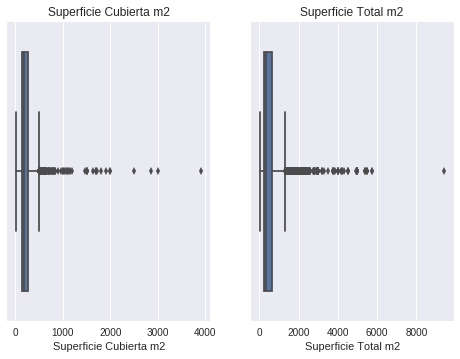

In [0]:
# Analysing outliers from 'Superficie Cubierta m2' & 'Superficie Total m2'
plt.subplot(1, 2, 1)
sns.boxplot(df['Superficie Cubierta m2'])
plt.title('Superficie Cubierta m2')
plt.subplot(1, 2, 2)
sns.boxplot(df['Superficie Total m2'])
plt.title('Superficie Total m2')
print('Lenght:',len(df)) #Lenght: 7225
plt.show()

Lenght: 9349


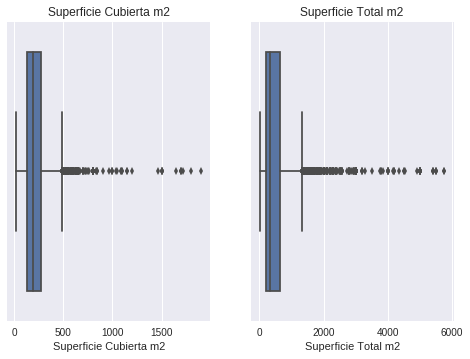

In [0]:
# Cleaning big outliers from 'Superficie Cubierta m2' & 'Superficie Total m2'
df = df.loc[(df['Superficie Cubierta m2'] < 2000) | (df['Superficie Cubierta m2'].isnull()) ]
df = df.loc[(df['Superficie Total m2'] < 6000) | (df['Superficie Total m2'].isnull()) ]

# Plotting results
plt.subplot(1, 2, 1)
sns.boxplot(df['Superficie Cubierta m2'])
plt.title('Superficie Cubierta m2')
plt.subplot(1, 2, 2)
sns.boxplot(df['Superficie Total m2'])
plt.title('Superficie Total m2')
print('Lenght:',len(df))
plt.show()

In [0]:
# Creating new columns with data about the replacement of NaN in 'Superficie Cubierta m2' & 'Superficie Total m2'
for i in ['Superficie Cubierta m2', 'Superficie Total m2']:
  df[i + '_was_missing'] = df[i].isnull()
df.head()

,Tipo de Propiedad,Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Valor,Cantidad de Cocheras_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Barrio_was_missing,Zona,Zona_was_missing,Tipo de Barrio,Tipo de Barrio_was_missing,Superficie Cubierta m2_was_missing,Superficie Total m2_was_missing
0,Duplex,Claros del Bosque,3.000,3.000,1.000,160.000,180.000,185000.000,False,False,False,False,Sur,False,Cerrado,False,False,False
1,Duplex,Greenville 2,3.000,2.000,0.000,nan,nan,225000.000,True,False,True,False,Sur,False,Con Seguridad,False,True,True
2,Casa,La Herradura,3.000,3.000,2.000,400.000,1592.000,380000.000,False,False,False,False,Cerro-Argüello,False,Country,False,False,False
4,Casa,Maipú Sección 2,4.000,4.000,2.000,316.000,350.000,250000.000,False,False,False,False,Sudeste,False,Abierto,False,False,False
6,Casa,Maipú Sección 2,3.000,2.000,1.000,221.000,296.000,135000.000,False,False,False,False,Sudeste,False,Abierto,False,False,False


Lenght: 5169


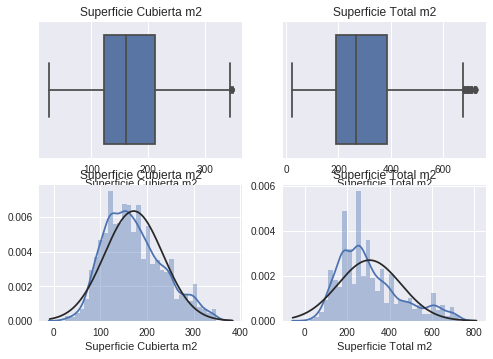

In [0]:
# Plotting distributions of 'Superficie Cubierta m2' & 'Superficie Total m2'
sup = df.dropna(subset=['Superficie Cubierta m2','Superficie Total m2'])

sup = sup.loc[(sup['Superficie Cubierta m2'] < 350) ]
sup = sup.loc[(sup['Superficie Total m2'] < 730) ]

# Plotting results
plt.subplot(2, 2, 1)
sns.boxplot(sup['Superficie Cubierta m2'])
plt.title('Superficie Cubierta m2')
plt.subplot(2, 2, 2)
sns.boxplot(sup['Superficie Total m2'])
plt.title('Superficie Total m2')
print('Lenght:',len(sup))

plt.subplot(2, 2, 3)
sns.distplot(sup['Superficie Cubierta m2'], fit=norm)
plt.title('Superficie Cubierta m2')
plt.subplot(2, 2, 4)
sns.distplot(sup['Superficie Total m2'], fit=norm)
plt.title('Superficie Total m2')

plt.show()

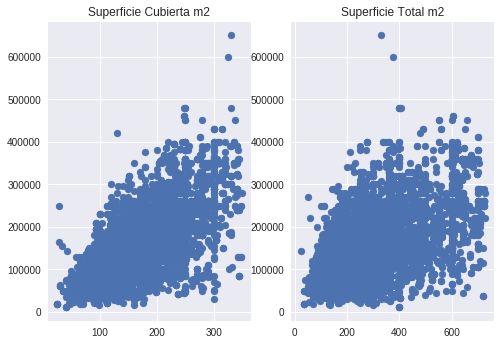

In [0]:
# Analysing correlations between Valor', Superficie Cubierta m2' & 'Superficie Total m2'
plt.subplot(1, 2, 1)
plt.scatter(sup['Superficie Cubierta m2'], sup.Valor)
plt.title('Superficie Cubierta m2')
plt.subplot(1, 2, 2)
plt.scatter(sup['Superficie Total m2'], sup.Valor)
plt.title('Superficie Total m2')
plt.show() # There are positive correlations between 'Superficie Cubierta m2'&'Superficie Total m2' and 'Valor'

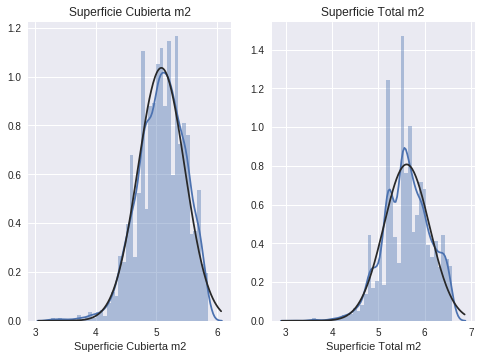

In [0]:
#Apply np.log1p which applies log(1+x) to all elements of 'Superficie Cubierta m2' & 'Superficie Total m2', normalizing their distributions
sup['Superficie Cubierta m2'] = np.log1p(sup['Superficie Cubierta m2'])
sup['Superficie Total m2'] = np.log1p(sup['Superficie Total m2'])

#Checking the new distributions
plt.subplot(1, 2, 1)
sns.distplot(sup['Superficie Cubierta m2'], fit=norm)
plt.title('Superficie Cubierta m2')
plt.subplot(1, 2, 2)
sns.distplot(sup['Superficie Total m2'], fit=norm)
plt.title('Superficie Total m2')

plt.show()

Mean: 12 | Standard Deviation: 1


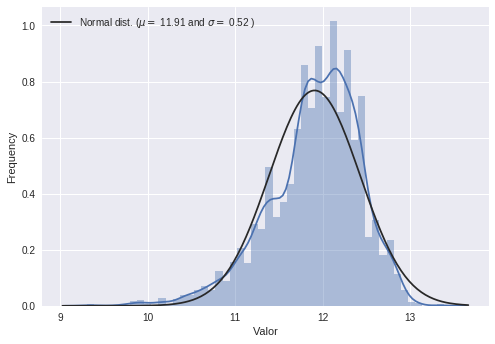

In [0]:
#Apply np.log1p which applies log(1+x) to all elements of the column 'Valor', normalizing its distribution
sup.Valor = np.log1p(sup.Valor)

#Checking the new distribution 
mu, sigma = norm.fit(sup.Valor)
print('Mean: %s | Standard Deviation: %s'%("%.0f"% mu,"%.0f"% sigma)) 

sns.distplot(sup.Valor, fit=norm) 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

plt.show() 

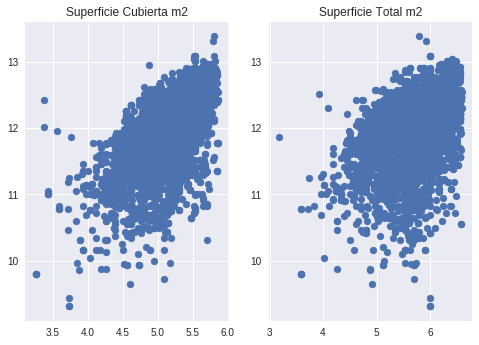

In [0]:
# Analysing correlations between Valor', Superficie Cubierta m2' & 'Superficie Total m2'
plt.subplot(1, 2, 1)
plt.scatter(sup['Superficie Cubierta m2'], sup.Valor)
plt.title('Superficie Cubierta m2')
plt.subplot(1, 2, 2)
plt.scatter(sup['Superficie Total m2'], sup.Valor)
plt.title('Superficie Total m2')
plt.show() # There are positive correlations between 'Superficie Cubierta m2'&'Superficie Total m2' and 'Valor'

In [0]:
col = ['Valor',
       'Cantidad de Dormitorios',
       'Cantidad de Baños',
       'Superficie Cubierta m2',
       'Superficie Total m2',
      ]
sup = sup[col]
sup.head()

,Valor,Cantidad de Dormitorios,Cantidad de Baños,Superficie Cubierta m2,Superficie Total m2
0,12.128,3.000,3.000,5.081,5.198
4,12.429,4.000,4.000,5.759,5.861
6,11.813,3.000,2.000,5.403,5.694
9,11.736,3.000,1.000,5.226,6.078
10,11.951,3.000,2.000,5.081,5.707


In [0]:
X = sup.drop(columns=['Superficie Cubierta m2', 'Superficie Total m2'])
y = sup['Superficie Cubierta m2']

In [0]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def log_XGB (X,y):
    # Split into validation and training data
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

    # Make validation predictions and calculate mean absolute error
    def get_mae(m, train_X, val_X, train_y, val_y):
        my_model = XGBRegressor(n_estimators=50000, learning_rate=0.01)
        my_model.fit(train_X, train_y, early_stopping_rounds=m, eval_set=[(val_X, val_y)], verbose=False)
        predictions = my_model.predict(val_X)
        mae = mean_absolute_error(np.expm1(predictions), np.expm1(val_y))
        return mae

    mae_values = {}

    for max_leaf_nodes in range(0,300, 10):
      mae_values[max_leaf_nodes] = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    min_mae_value = min(mae_values, key=mae_values.get)
    print("   * XGBRegressor with early_stopping_rounds: {:,.2f}".format(mae_values[min_mae_value]), 
          '(with',min_mae_value, 'stops)')
    return min_mae_value

In [0]:
m = log_XGB (X,y)

   * XGBRegressor with early_stopping_rounds: 32.70 (with 290 stops)


In [0]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = XGBRegressor(n_estimators=50000, learning_rate=0.01)
my_model.fit(train_X, train_y, early_stopping_rounds=m, eval_set=[(val_X, val_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
X = df.loc[df['Superficie Cubierta m2'].isnull()]
X = X[['Valor','Cantidad de Dormitorios','Cantidad de Baños']]
X.Valor = np.log1p(X.Valor)
predictions = my_model.predict(X)
print(len(predictions))
print(len(df['Superficie Cubierta m2'][df['Superficie Cubierta m2'].isnull()]))

2063
2063


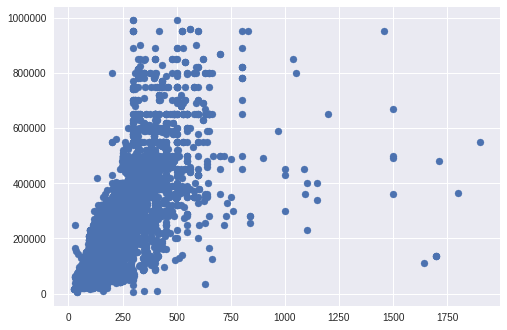

In [0]:
df['Superficie Cubierta m2'][df['Superficie Cubierta m2'].isnull()] = np.expm1(predictions)
plt.scatter(df['Superficie Cubierta m2'], df.Valor)

In [0]:
X = sup.drop(columns=['Superficie Cubierta m2', 'Superficie Total m2'])
y = sup['Superficie Total m2']

m = log_XGB (X,y)

   * XGBRegressor with early_stopping_rounds: 95.02 (with 170 stops)


In [0]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = XGBRegressor(n_estimators=50000, learning_rate=0.01)
my_model.fit(train_X, train_y, early_stopping_rounds=m, eval_set=[(val_X, val_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
X = df.loc[df['Superficie Total m2'].isnull()]
X = X[['Valor','Cantidad de Dormitorios','Cantidad de Baños']]
X.Valor = np.log1p(X.Valor)
predictions = my_model.predict(X)
print(len(predictions))
print(len(df['Superficie Total m2'][df['Superficie Total m2'].isnull()]))

1922
1922


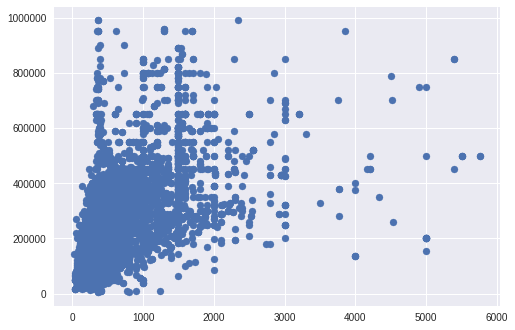

In [0]:
df['Superficie Total m2'][df['Superficie Total m2'].isnull()] = np.expm1(predictions)
plt.scatter(df['Superficie Total m2'], df.Valor)

In [0]:
print('Lenght:', len(df))

Lenght: 9349


## **Final integration of the DataFrame**

In [0]:
# Checking for NaN in the entire DataFrame
for i in df.columns:
  df[i] = df[i].replace('nan',np.NaN)
df.isnull().sum()

Tipo de Propiedad                      0
Barrio                                 0
Cantidad de Dormitorios                0
Cantidad de Baños                      0
Cantidad de Cocheras                   0
Superficie Cubierta m2                 0
Superficie Total m2                    0
Valor                                  0
Cantidad de Cocheras_was_missing       0
Cantidad de Dormitorios_was_missing    0
Cantidad de Baños_was_missing          0
Barrio_was_missing                     0
Zona                                   0
Zona_was_missing                       0
Tipo de Barrio                         0
Tipo de Barrio_was_missing             0
Superficie Cubierta m2_was_missing     0
Superficie Total m2_was_missing        0
dtype: int64

In [0]:
# Re-ordening all the columns in the dataframe
col = ['Tipo de Propiedad',
       'Zona',
       'Barrio',
       'Tipo de Barrio',
       'Cantidad de Dormitorios',
       'Cantidad de Baños',
       'Cantidad de Cocheras',
       'Superficie Cubierta m2',
       'Superficie Total m2',
       'Zona_was_missing',
       'Barrio_was_missing',
       'Tipo de Barrio_was_missing',
       'Cantidad de Dormitorios_was_missing',
       'Cantidad de Baños_was_missing',
       'Cantidad de Cocheras_was_missing',
       'Superficie Cubierta m2_was_missing',
       'Superficie Total m2_was_missing',
       'Valor',
      ] 
df = df[col]
print('Lenght:', len(df))  
df.head()

Lenght: 9349


,Tipo de Propiedad,Zona,Barrio,Tipo de Barrio,Cantidad de Dormitorios,Cantidad de Baños,Cantidad de Cocheras,Superficie Cubierta m2,Superficie Total m2,Zona_was_missing,Barrio_was_missing,Tipo de Barrio_was_missing,Cantidad de Dormitorios_was_missing,Cantidad de Baños_was_missing,Cantidad de Cocheras_was_missing,Superficie Cubierta m2_was_missing,Superficie Total m2_was_missing,Valor
0,Duplex,Sur,Claros del Bosque,Cerrado,3.000,3.000,1.000,160.000,180.000,False,False,False,False,False,False,False,False,185000.000
1,Duplex,Sur,Greenville 2,Con Seguridad,3.000,2.000,0.000,182.136,296.814,False,False,False,False,True,True,True,True,225000.000
2,Casa,Cerro-Argüello,La Herradura,Country,3.000,3.000,2.000,400.000,1592.000,False,False,False,False,False,False,False,False,380000.000
4,Casa,Sudeste,Maipú Sección 2,Abierto,4.000,4.000,2.000,316.000,350.000,False,False,False,False,False,False,False,False,250000.000
6,Casa,Sudeste,Maipú Sección 2,Abierto,3.000,2.000,1.000,221.000,296.000,False,False,False,False,False,False,False,False,135000.000


In [0]:
a = {}
for i in df.Barrio.unique():
  a[i] = len(df.loc[df.Barrio == i]) 
a

{'1 de Mayo': 8,
 '20 de Junio': 6,
 'ATE': 10,
 'Acosta': 5,
 'Aeronáutico': 3,
 'Alameda': 2,
 'Alberdi': 94,
 'Alberto': 1,
 'Alejandro Centeno': 55,
 'Alta Córdoba': 182,
 'Altamira': 13,
 'Alto Alberdi': 144,
 'Alto Palermo': 36,
 'Alto Verde': 71,
 'Altos de La Calera': 3,
 'Altos de Manantiales': 35,
 'Altos de San Martín': 7,
 'Altos de Villa Cabrera': 15,
 'Altos de Vélez Sársfield': 10,
 'Altos del Chateau': 25,
 'Ameghino Norte': 2,
 'Ameghino Sud': 11,
 'Amp. Res. America': 16,
 'Ampliación Jardín Espinosa': 1,
 'Ampliación Pueyrredón': 2,
 'Ampliación Residencial América': 1,
 'Argüello': 359,
 'Argüello Norte': 26,
 'Avenida': 5,
 'Ayacucho': 51,
 'Ayres del Sur': 6,
 'Bajo Galán': 2,
 'Bajo General Paz': 1,
 'Barrancas Norte': 3,
 'Bella Vista': 14,
 'Bialet Massé': 12,
 'Brigadier San Martín': 1,
 'Cabo Farina': 1,
 'Caseros': 1,
 'Casonas Del Sur': 3,
 'Cañuelas': 30,
 'Centenario': 49,
 'Centro': 141,
 'Centro América': 25,
 'Cerro Chico': 24,
 'Cerro Norte': 6,
 'Cer

## **Exporting cleaned DataFrame**

In [0]:
df.to_csv('Cleaned_Venta_casas.csv', encoding='utf_8_sig')